# Natural Language as a sequential data

* Barabási-Albert Model
* analysis of Peseudo data

In [1]:
#mathematics
using LinearAlgebra
using SparseArrays

#statistics
using Random
using StatsBase
using Statistics
using Distributions

#dataframe
using DataFrames

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

## Part1: What is `Barabási-Albert model`?<hr>

## 1-1. Define functions

In [2]:
#normalize
function normalize(vec)
    S = sum(vec)
    if S>0
        return vec/sum(vec)
    else
        vec[1] = 1
        return vec
    end
end
    
#initialize the graph
function initialize!(adj,m)
    for j in 1:m
       for k in j+1:m
            adj[k,j] = 1
            adj[j,k] = 1
        end
    end
end

#choose m nodes
function choose_nodes(adj,m)
    probs = normalize(sum(adj,dims=2)[:])
    return rand(Categorical(probs),m)
end

#update adjacency matrix
function update_adj!(adj,nodes,v)
    adj[nodes,v] = ones(Int64,m)
    adj[v,nodes] = ones(Int64,m)
end

#V nodes each of which has m edges
function BAmodel(m,V)
    adj = spzeros(Int64,V,V)
    nodes = zeros(Int64,m)
    initialize!(adj,m)
    @showprogress for v in m+1:V
        nodes = choose_nodes(adj,m)
        update_adj!(adj,nodes,v)
    end
    return adj
end

#choose the next node
function walk(current_node,adj,edges)
    nodes = adj[:,current_node].nzind
    probs = normalize(edges[nodes])
    idx = rand(Categorical(probs))
    return nodes[idx]
end

#random walk
function myRW(adj,m,V,N)
    edges = sum(adj,dims=2)[:]
    current_node = 1#rand(1:V)
    path = zeros(Int64,N)
    path[1] = current_node
    @showprogress for n in 2:N
        current_node = walk(current_node,adj,edges)
        path[n] = current_node
    end
    return path
end

myRW (generic function with 1 method)

## 1-2. Visualize `Barabási-Albert network`

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


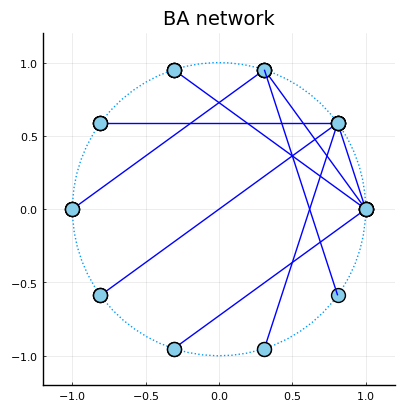

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/ML/NLP/statistical universals/figs-NLPSD/anim1.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/FCM0H/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/ML/NLP/statistical universals/figs-NLPSD/anim1.gif")
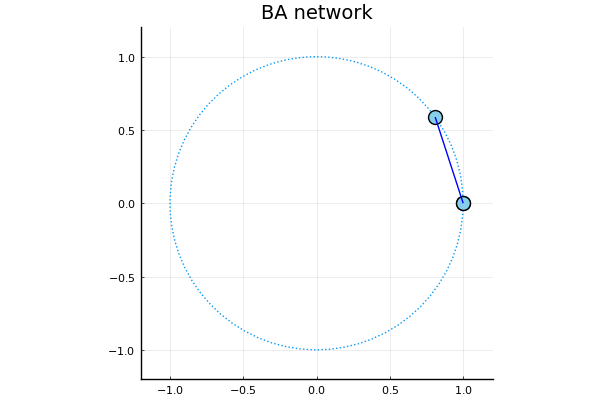

In [3]:
#set the random seed
Random.seed!(42)

#create the BA network
m = 1
V = Int(1e1)
adj = BAmodel(m,V)

#animation
θ = 2π/V
ts = 0:0.1:2π+0.1
coss = [cos(i*θ) for i in 0:V-1]
sins = [sin(i*θ) for i in 0:V-1]
plot(cos.(ts),sin.(ts),xlim=(-1.2,1.2),ylim=(-1.2,1.2),label=false,ls=:dot,aspect_ratio=:equal,title="BA network")
plot!(coss[1:1],sins[1:1],st=:scatter,color=:skyblue,markersize=10,label=false)
anim = @animate for v in 2:V
    plot!(coss[1:v],sins[1:v],st=:scatter,color=:skyblue,markersize=10,label=false)
    to_v = adj[v,1:v].nzind[1]
    plot!([coss[v],coss[to_v]],[sins[v],sins[to_v]],color=:blue,label=false)
end
gif(anim,"figs-NLPSD/anim1.gif",fps=1)

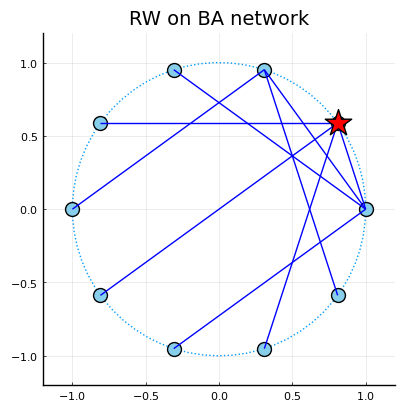

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/ML/NLP/statistical universals/figs-NLPSD/anim2.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/FCM0H/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/ML/NLP/statistical universals/figs-NLPSD/anim2.gif")
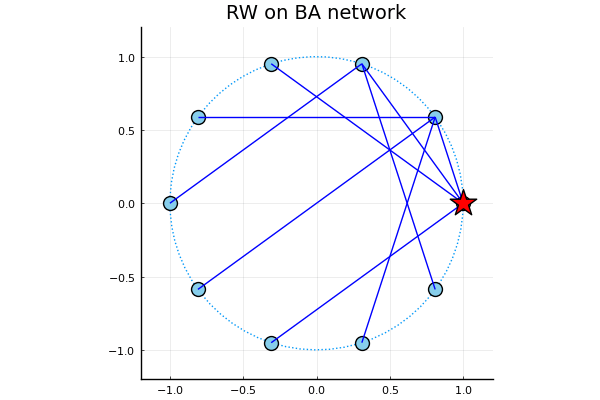

In [4]:
#set the random seed
Random.seed!(42)

#create the BA network
m = 1
V = Int(1e1)
adj = BAmodel(m,V)

#BA network
θ = 2π/V
ts = 0:0.1:2π+0.1
coss = [cos(i*θ) for i in 0:V-1]
sins = [sin(i*θ) for i in 0:V-1]
ba_plot = plot(cos.(ts),sin.(ts),xlim=(-1.2,1.2),ylim=(-1.2,1.2),label=false,ls=:dot,aspect_ratio=:equal,title="RW on BA network")
plot!(coss,sins,st=:scatter,color=:skyblue,markersize=10,label=false)
for v in 2:V
    to_v = adj[v,1:v].nzind[1]
    plot!([coss[v],coss[to_v]],[sins[v],sins[to_v]],color=:blue,label=false)
end

#random walk on BA network
N = 50
history = myRW(adj,m,V,N)
anim = @animate for n in 1:N
    plot(ba_plot)
    plot!([coss[history[n]],],[sins[history[n]],],st=:scatter,color="red",markersize=20,markershape=:star,label=false)
end
gif(anim,"figs-NLPSD/anim2.gif",fps=1)

## Part2: Words interval distribution <hr>

## 2-1. Create data

In [5]:
#set the random seed
Random.seed!(42)

#create the BA network
m = 1
V = Int(1e5)
adj = BAmodel(m,V)

#create word sequence
N = Int(1e6)
W = myRW(adj,m,V,N)
n_unique = length(unique(W))

#data
data = (W=W,V=V,N=N,n_unique=n_unique)
println("The number of vocabrary = $(V). ")
println("The document has $(N) words in total. ")
println("The document has $(n_unique) unique words in total. ")

Progress: 100%|█████████████████████████████████████████| Time: 0:13:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


The number of vocabrary = 100000. 
The document has 1000000 words in total. 
The document has 41936 unique words in total. 


## 2-2. Define functions

In [6]:
#word dataframe
word_df(W) = DataFrame(word_id=W)

#word frequency dataframe(sorted)
function word_freq_df(df)
    word_cnt_df = combine(nrow,groupby(df,:word_id))
    return sort(word_cnt_df,:nrow,rev=:true)
end

#unify rare wards lowest 1/Ψ
function unify_rare_words(data,my_word_freq_df,Ψ)
    @unpack W,N,V,n_unique = data
    Wrare = zeros(Int64,N)
    rare_word_id = maximum(W)+1
    sorted_freqs = sort(my_word_freq_df,:nrow)
    rare_words = sorted_freqs[cumsum(sorted_freqs.nrow) .< Int(floor(N/Ψ)),:].word_id
    for n in 1:N
        if W[n] in rare_words
            Wrare[n] = rare_word_id
        end
    end
    return Wrare, rare_word_id
end

#interval sequence for a specific word
function Qv_df(W,v)
    is_v_idx = SparseVector(W.==v).nzind
    Qv = is_v_idx[begin+1:end] - is_v_idx[begin:end-1]
    df = DataFrame(Qv=Qv)
    freq_df = combine(nrow,groupby(df,:Qv))
    return df, sort(freq_df,:nrow)
end

#cumulative distribution lower than q
cumv(q,Qv_freq_df) = sum(Qv_freq_df[Qv_freq_df.Qv.<=q,:].nrow)
function cumvvec(qs,W,v)
    freq_v = sum(W.==v)
    n_qs = length(qs)
    cums = zeros(n_qs)
    _, Qv_freq_df = Qv_df(W,v)
    @showprogress for j in 1:n_qs
        cums[j] = cumv(qs[j],Qv_freq_df)
    end
    return cums/(freq_v-1)
end

cumvvec (generic function with 1 method)

## 2-3. Excess Probability

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


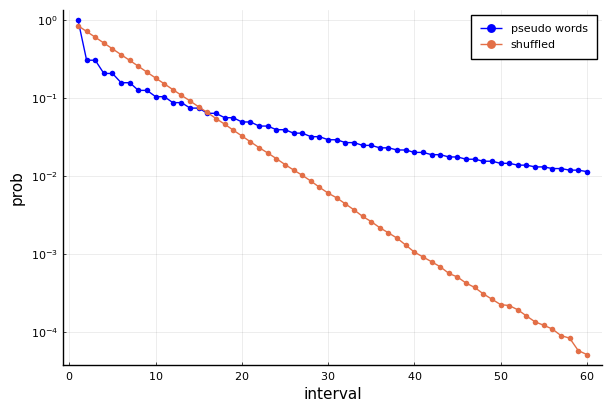

In [7]:
#frequency
my_word_df = word_df(W)
my_word_freq_df = word_freq_df(my_word_df)
qs = 1:60

#visualize (puseudo words data)
excess_probs = 1 .- cumvvec(qs,W,1)
fig = plot(qs,excess_probs,xlabel="interval",ylabel="prob",yscale=:log10,color=:blue,
    marker=:circle,markerstrokewidth=0,label="pseudo words")

#visualize (shuffle words)
shuffled_W = shuffle(W)
excess_probs = 1 .- cumvvec(qs,shuffled_W,1)
plot!(qs,excess_probs,xlabel="interval",ylabel="prob",yscale=:log10,
    marker=:circle,markerstrokewidth=0,label="shuffled")
savefig(fig,"figs-NLPSD/fig.png")